In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torch.distributions
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
training_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z  

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
d = 4
vae = VariationalAutoencoder(latent_dims=d)

optim = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [8]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    num = len(dataloader.dataset)// batch_size
    for batch, (x, _) in enumerate(dataloader): 
        x = x.to(device)
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 200 == 0 :
            print(f'[{batch}/{num}] Current Loss: {loss.item():.3f}')
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [9]:
num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(vae,device,train_dataloader,optim)
    print(f'\n EPOCH {epoch+1}/{num_epochs} \t train loss {train_loss:>.3f}')
    

  0%|          | 0/50 [00:00<?, ?it/s]

[0/937] Current Loss: 10094.338
[200/937] Current Loss: 2673.066
[400/937] Current Loss: 2049.251
[600/937] Current Loss: 1849.178
[800/937] Current Loss: 1898.600

 EPOCH 1/50 	 train loss 41.274
[0/937] Current Loss: 1810.172
[200/937] Current Loss: 1752.078
[400/937] Current Loss: 1783.873
[600/937] Current Loss: 1734.653
[800/937] Current Loss: 1744.457

 EPOCH 2/50 	 train loss 28.199
[0/937] Current Loss: 1760.011
[200/937] Current Loss: 1678.391
[400/937] Current Loss: 1717.838
[600/937] Current Loss: 1705.555
[800/937] Current Loss: 1729.577

 EPOCH 3/50 	 train loss 27.427
[0/937] Current Loss: 1726.301
[200/937] Current Loss: 1657.930
[400/937] Current Loss: 1723.980
[600/937] Current Loss: 1694.877
[800/937] Current Loss: 1712.164

 EPOCH 4/50 	 train loss 27.019
[0/937] Current Loss: 1733.710
[200/937] Current Loss: 1651.484
[400/937] Current Loss: 1683.734
[600/937] Current Loss: 1662.935
[800/937] Current Loss: 1694.894

 EPOCH 5/50 	 train loss 26.776
[0/937] Current Los

[800/937] Current Loss: 1604.178

 EPOCH 42/50 	 train loss 25.301
[0/937] Current Loss: 1586.671
[200/937] Current Loss: 1499.094
[400/937] Current Loss: 1603.571
[600/937] Current Loss: 1591.115
[800/937] Current Loss: 1579.592

 EPOCH 43/50 	 train loss 25.299
[0/937] Current Loss: 1611.311
[200/937] Current Loss: 1532.310
[400/937] Current Loss: 1608.425
[600/937] Current Loss: 1592.192
[800/937] Current Loss: 1581.352

 EPOCH 44/50 	 train loss 25.297
[0/937] Current Loss: 1593.000
[200/937] Current Loss: 1535.155
[400/937] Current Loss: 1602.520
[600/937] Current Loss: 1558.851
[800/937] Current Loss: 1615.849

 EPOCH 45/50 	 train loss 25.283
[0/937] Current Loss: 1570.515
[200/937] Current Loss: 1523.946
[400/937] Current Loss: 1612.458
[600/937] Current Loss: 1591.143
[800/937] Current Loss: 1582.426

 EPOCH 46/50 	 train loss 25.278
[0/937] Current Loss: 1574.967
[200/937] Current Loss: 1503.231
[400/937] Current Loss: 1598.024
[600/937] Current Loss: 1556.750
[800/937] Curre

In [10]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

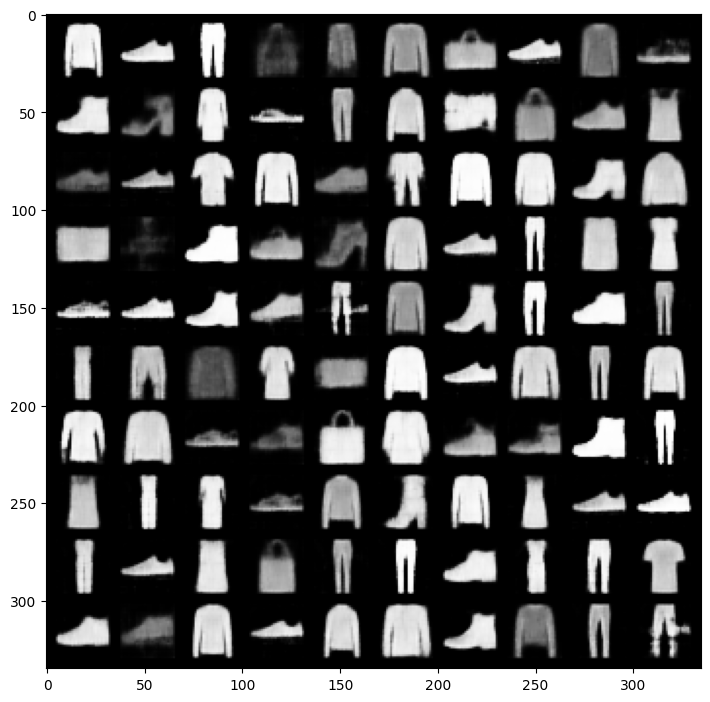

In [12]:

vae.eval()

with torch.no_grad():
    latent = torch.randn(128, d, device=device)

    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()